## Будникова Валерия Павловна М8О-407Б-19
## Лабораторная работа 4


In [5]:
# !unzip /content/archive-5.zip -d /content/archive

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
#обьединение нескольких преобразований изображений с помощью transforms.Compose
# transforms.RandomResizedCrop - обрезка изображения в квадрат 
# transforms.RandomHorizontalFlip - отражение изображения по горизонтальной оси
# transforms.ToTensor - перобразование данных в тензоры
# transforms.Normalize - нормализация данных
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# загрузка данных, разделение их на тренировочные и валидационные 
data_dir = '/content/archive/archive-5'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
#определение размера данных и названий лейблов классов 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# выбор гарфического процессора, если такой не поддерживается, то расчеты будут проводится на cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

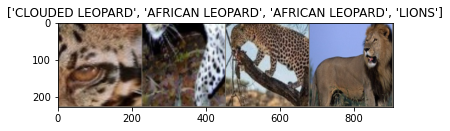

In [8]:
# функция для отрисовки изображений  
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# отрисовка изображений
imshow(out, title=[class_names[x] for x in classes])

In [9]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # инициализация начала времени обучения
    since = time.time()


    # задаются изначальные значения для лучших параметров модели (делается полная копия параметров модели)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # цикл эпох
    for epoch in range(num_epochs):
        # печать информации
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # смена режимов модели - на обучение или тестирование
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # инициализация параметра потерь и правильно угаданных вариантов
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # прермещение данных на выбранный процессор 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients - обнуление градиентов
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # предсказание модели
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # расчет потерь
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    # обратный проход для корректировки весов
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # обновление потерь и правильно угаданных классов
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                #обновление функции потерь
                scheduler.step()

            #сбор информации для дальнейшего использования(визуализации для пользователи)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            # обновление значений для лучших параметров модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    # инициализация конца времени обучения
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # загрузка лучших параметров модели
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# функция для отрисовки полученных результатов 
# модель используется в режиме .eval() 
# с помощтю бибилиотеки matplotlib.pyplot рисуются изображения 
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
# загружается уже обученныя модель resnet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# добавляется линейный слой, количество выходов устанавливается количеством классов выбранного датасета 
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# "перемещение" обучения на выбранный процессор
model_ft = model_ft.to(device)

# инициализация функции потерь
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# инициализация оптимизатора
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# каждые step_size эпох коэффициент learning rate будет уменьшаться в gamma раз
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
# обучение модели
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3842 Acc: 0.5254
val Loss: 0.3839 Acc: 0.8600

Epoch 1/9
----------
train Loss: 1.0471 Acc: 0.6550
val Loss: 1.0482 Acc: 0.8200

Epoch 2/9
----------
train Loss: 0.9672 Acc: 0.6866
val Loss: 0.2644 Acc: 0.9200

Epoch 3/9
----------
train Loss: 0.6916 Acc: 0.7743
val Loss: 0.2066 Acc: 0.9200

Epoch 4/9
----------
train Loss: 0.6038 Acc: 0.8080
val Loss: 0.0822 Acc: 0.9800

Epoch 5/9
----------
train Loss: 0.5610 Acc: 0.8196
val Loss: 0.0629 Acc: 0.9800

Epoch 6/9
----------
train Loss: 0.5301 Acc: 0.8311
val Loss: 0.0593 Acc: 0.9800

Epoch 7/9
----------
train Loss: 0.5801 Acc: 0.8157
val Loss: 0.0719 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.5284 Acc: 0.8316
val Loss: 0.0672 Acc: 0.9800

Epoch 9/9
----------
train Loss: 0.5276 Acc: 0.8260
val Loss: 0.0607 Acc: 1.0000

Training complete in 2m 47s
Best val Acc: 1.000000


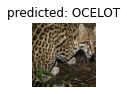

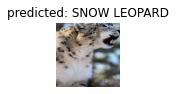

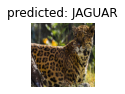

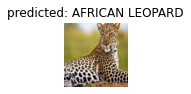

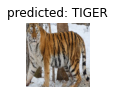

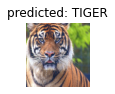

In [13]:
# просмотр результатов
visualize_model(model_ft)

In [14]:
# загружается уже обученныя модель resnet18
model_conv = torchvision.models.resnet18(pretrained=True)
# устанавливается запрет на изменение весов уже обученной части модели
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# добавляется линейный слой, количество выходов устанавливается количеством классов выбранного датасета 
# градиеття в это линейном слое ститаются, т. е. в нем происходит измененние весов 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

# "перемещение" обучения на выбранный процессор
model_conv = model_conv.to(device)

# инициализация функции потерь
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# инициализация оптимизатора
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# каждые step_size эпох коэффициент learning rate будет уменьшаться в gamma раз
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [15]:
# обучение модели
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.5748 Acc: 0.4596
val Loss: 0.5264 Acc: 0.8400

Epoch 1/9
----------
train Loss: 1.1851 Acc: 0.5909
val Loss: 0.5043 Acc: 0.8600

Epoch 2/9
----------
train Loss: 1.0686 Acc: 0.6460
val Loss: 0.4992 Acc: 0.8200

Epoch 3/9
----------
train Loss: 0.8949 Acc: 0.7003
val Loss: 0.4801 Acc: 0.8400

Epoch 4/9
----------
train Loss: 0.9190 Acc: 0.6952
val Loss: 0.5569 Acc: 0.8000

Epoch 5/9
----------
train Loss: 0.8782 Acc: 0.7101
val Loss: 0.5968 Acc: 0.8200

Epoch 6/9
----------
train Loss: 0.8893 Acc: 0.7050
val Loss: 0.4508 Acc: 0.8600

Epoch 7/9
----------
train Loss: 0.8547 Acc: 0.7200
val Loss: 0.4763 Acc: 0.8000

Epoch 8/9
----------
train Loss: 0.8890 Acc: 0.7003
val Loss: 0.5138 Acc: 0.8200

Epoch 9/9
----------
train Loss: 0.8523 Acc: 0.7127
val Loss: 0.4721 Acc: 0.8400

Training complete in 1m 46s
Best val Acc: 0.860000


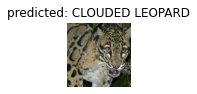

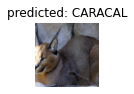

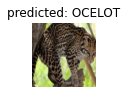

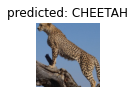

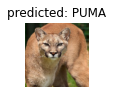

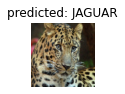

In [16]:
# просмотр результатов
visualize_model(model_conv)

plt.ioff()
plt.show()